## Import Libraries

In [126]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

## Load the Data

In [3]:
df = pd.read_csv("cleanfootball.csv")

In [4]:
df.shape

(10746, 19)

In [8]:
df.head(2)

,Unnamed: 0,team,name,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,0,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.0,0.0,0.009585,0.0,0.0,0.335463,9390,42,5,13,15000000,70000000
1,1,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,0.207055,1304,510,58,1,1500000,22000000


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [12]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,Unnamed: 0,team,name,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value


In [14]:
# Completeness
df.isnull().sum()

Unnamed: 0             0
team                   0
name                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
dtype: int64

In [16]:
# Accurecy types
df.dtypes

Unnamed: 0               int64
team                    object
name                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
dtype: object

In [20]:
categorical_columns = []
numerical_columns = []

for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        numerical_columns.append(column)
    elif pd.api.types.is_categorical_dtype(df[column]) or df[column].dtype == object:
        categorical_columns.append(column)

print("Categorical columns:", categorical_columns)
print("Numerical columns:", numerical_columns)


Categorical columns: ['team', 'name', 'position']
Numerical columns: ['Unnamed: 0', 'height', 'age', 'appearance', 'goals', 'assists', 'yellow cards', 'second yellow cards', 'red cards', 'clean sheets', 'minutes played', 'days_injured', 'games_injured', 'award', 'current_value', 'highest_value']


In [22]:
for i in categorical_columns:
    print (df[i].value_counts())
    

team
Jeonbuk Hyundai Motors    46
Daejeon Hana Citizen      46
FC Seoul                  45
Gangwon FC                43
Daegu FC                  42
                          ..
FC Barcelona              22
Atlético de Madrid        22
CA Osasuna                22
Hatayspor                 11
Gaziantep FK               6
Name: count, Length: 374, dtype: int64
name
Paulinho              6
Guilherme             5
Vitinho               5
João Pedro            4
Fernando              4
                     ..
Janderson             1
Everson               1
Matheus Mendes        1
Gabriel Delfim        1
Alexander Badolato    1
Name: count, Length: 10576, dtype: int64
position
Defender Centre-Back          1821
Attack Centre-Forward         1352
Goalkeeper                    1227
midfield-CentralMidfield      1149
midfield-DefensiveMidfield     899
Defender Right-Back            867
Defender Left-Back             807
midfield-AttackingMidfield     768
Attack-LeftWinger              714
Att

In [71]:
df.shape

(5364, 11)

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [81]:
df.head(2)

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000


In [24]:
categorical_columns

['team', 'name', 'position']

In [26]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_columns)

In [28]:
df.shape

(10746, 10982)

In [30]:
df.head(2)

,Unnamed: 0,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,clean sheets,...,position_Defender Centre-Back,position_Defender Left-Back,position_Defender Right-Back,position_Goalkeeper,position_midfield,position_midfield-AttackingMidfield,position_midfield-CentralMidfield,position_midfield-DefensiveMidfield,position_midfield-LeftMidfield,position_midfield-RightMidfield
0,0,189.0,32.0,104,0.0,0.0,0.009585,0.0,0.0,0.335463,...,False,False,False,True,False,False,False,False,False,False
1,1,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,0.207055,...,False,False,False,True,False,False,False,False,False,False


In [32]:
# Calculate the 35th and 75th percentiles of the price
p35 = df['current_value'].quantile(0.35)
p75 = df['current_value'].quantile(0.75)

# Function to categorize prices
def categorize_price(current_value):
    if current_value < p35:
        return 'Cheap_Price'
    elif current_value < p75:
        return 'Good_Price'
    else:
        return 'High_Price'

# Apply the function to create a new column
df['current_value_new'] = df['current_value'].apply(categorize_price)

df.drop('current_value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['current_value_new'].value_counts())

current_value_new
Good_Price     4305
Cheap_Price    3751
High_Price     2690
Name: count, dtype: int64


In [34]:
p35, p75

(450000.0, 3000000.0)

In [36]:
print(df['current_value_new'].dtype)


object


In [38]:
# Check for missing values in the 'current_value_new' column
if df['current_value_new'].isnull().any():
    # Handle missing values if any (e.g., fill them, drop them, etc.)
    df['current_value_new'] = df['current_value_new'].fillna('Unknown')  # Example: fill NaNs with 'Unknown'

# Ensure the data type is suitable for LabelEncoder (e.g., string or categorical)
df['current_value_new'] = df['current_value_new'].astype(str)

# Initialize the LabelEncoder
encoder = LabelEncoder()

# Fit and transform the 'current_value_new' column
df['player_price_category_encoded'] = encoder.fit_transform(df['current_value_new'])


In [40]:
df['player_price_category_encoded']

0        2
1        1
2        1
3        2
4        2
        ..
10741    0
10742    0
10743    0
10744    0
10745    0
Name: player_price_category_encoded, Length: 10746, dtype: int64

#### 3. Feature selection

In [42]:
# Ensure numeric columns only
numeric_df = df.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation = numeric_df.corr()

# Print the correlation of 'player_price_category_encoded' with other numeric features
if 'player_price_category_encoded' in correlation.columns:
    print(correlation['player_price_category_encoded'].sort_values(ascending=False))
else:
    print("'player_price_category_encoded' is not a numeric column or is missing.")


player_price_category_encoded    1.000000
appearance                       0.547069
minutes played                   0.519534
highest_value                    0.488262
award                            0.242282
games_injured                    0.229162
days_injured                     0.197739
assists                          0.163664
goals                            0.120332
height                           0.024570
age                              0.023610
red cards                        0.013281
yellow cards                     0.012557
second yellow cards             -0.002962
clean sheets                    -0.031319
Unnamed: 0                      -0.539092
Name: player_price_category_encoded, dtype: float64


In [46]:
# Set the correlation threshold
threshold = 0.2  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['player_price_category_encoded']) > \
threshold]['player_price_category_encoded'].index
selected_features

Index(['Unnamed: 0', 'appearance', 'minutes played', 'games_injured', 'award',
       'highest_value', 'player_price_category_encoded'],
      dtype='object')

In [48]:
selected_features = ['appearance', 'minutes played', 'games_injured', 'award', 'highest_value',
                      'player_price_category_encoded']

In [50]:
df = df[selected_features]
df.head()

,appearance,minutes played,games_injured,award,highest_value,player_price_category_encoded
0,104,9390,5,13,70000000,2
1,15,1304,58,1,22000000,1
2,4,292,84,4,6000000,1
3,82,6408,22,9,50000000,2
4,63,5031,51,21,80000000,2


#### 4. Prepare train and test data

In [52]:
# Prepare data
X = df.drop(['player_price_category_encoded'], axis=1)
y = df['player_price_category_encoded']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [82]:
X.shape

(10746, 5)

In [84]:
X.head(2)

,appearance,minutes played,games_injured,award,highest_value
0,104,9390,5,13,70000000
1,15,1304,58,1,22000000


## Buliding the Model

In [87]:
model = KNeighborsClassifier()

In [89]:
param_grid = {
    'n_neighbors': [2, 3, 4, 5, 6, 7]
}
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro', 
                           verbose=1)

## Train the Model

In [92]:
# Fit the model on the training data
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7]}, scoring='f1_macro',
             verbose=1)

In [94]:
grid_search.best_params_

{'n_neighbors': 7}

In [96]:
model = grid_search.best_estimator_

## Test the Model

In [98]:
# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)

## Evaluating the Model 

In [101]:
# our benchmark model
base_model = round(df['player_price_category_encoded'].value_counts()[1]/df.shape[0]*100, 2)
base_model

40.06

1. Accuracy

In [104]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.713953488372093

In [106]:
y_pred_train = model.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_pred_train)
accuracy

0.783620288506282

In [108]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[529, 211,   5],
       [186, 621,  77],
       [  6, 130, 385]])

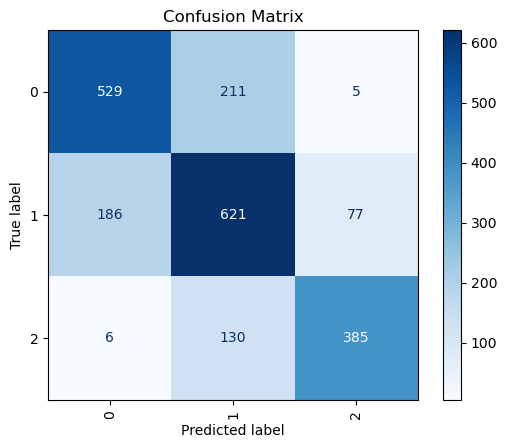

In [110]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        display_labels=model.classes_,
                                        cmap="Blues",
                                        xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

In [112]:
# Calculate Precision
precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.2f}")

Precision: 0.73


In [114]:
# Calculate Recall
recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall:.2f}")

Recall: 0.72


In [116]:
# Calculate F1 Score
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.72


In [128]:
print(classification_report(y_test,
                      y_pred,
                      labels=list(model.classes_)))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       745
           1       0.65      0.70      0.67       884
           2       0.82      0.74      0.78       521

    accuracy                           0.71      2150
   macro avg       0.73      0.72      0.72      2150
weighted avg       0.72      0.71      0.72      2150

